In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from ops import *
from models import *
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import functools
import math

from params import *

from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv

env = gym.make(envs[env_to_use]).unwrapped
if discrete_actions:
    creature_out_size = env.action_space.n
else:
    creature_out_size = env.action_space.shape[0]
    

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
output_num = len(get_params(Creature(env.observation_space.shape[0],creature_out_size)))
input_num = output_num*2


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
def evolve(population,population_out_size,gen,p_fitness,mutation_rate,mutation_scale,lr):
    #Chose creatures based on fitness
    sort = np.argsort(np.max(p_fitness)-p_fitness)
    p_exp = population_exponent
    if population_exponent <= 0:
        p_exp = fitness
        
    choice = []
    for i in range(population_out_size+1):
        ex = (population_out_size)/p_exp#population_out_size
        ex = math.ceil(ex**(1/(i+1)))
        for _ in range(int(ex)):
            choice.append(sort[i%(len(p_fitness)-1)])
        if len(choice) > population_out_size+1:
            choice = choice[:population_out_size+1]
            break
    np.random.shuffle(choice)
    
    #mate and mutate creatures
    new_population = []
    for p in range(population_out_size):
        #Pick parents
        first_choice = population[choice[p]]
        second_choice = population[choice[p+1]]
        
        child = mate(env,creature_out_size,lr[p],device,first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],gen,mutation_scale).to(device)
        
        new_population.append(child)
        
    return new_population

In [3]:

def train_gan(population,p_fitness,batch_size = 20,n_epochs = 100):
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    gen_explore_all = []
    gen_exploit_all = []
    dis_loss_all = []
    dis_confidence_all = []
    for e in range(n_epochs):
        #shuffle arrays in unison
        ind = np.arange(len(population))
        np.random.shuffle(ind)
        population = np.array(population)[ind]
        p_fitness = p_fitness[ind]
        for i in range(len(population)//batch_size):
            
            #turn population into vectors
            real_batch = []
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            #train discriminator on population
            dis_optimizer.zero_grad()
            dis_out_r,_ = dis(real_batch)
            dis_out_r = dis_out_r.squeeze(-1)
            rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]
            dis_error_real = (torch.pow((dis_out_r[...,0]-rank),2))
            
            dis_error_real_mean = torch.mean(dis_error_real)
            dis_error_real_mean.backward(retain_graph=True)
            
            #discriminator confidence in its prediction
            dis_confidence = torch.mean(torch.pow(dis_out_r[...,1]-dis_error_real.detach(),2))
            dis_confidence.backward()
            
            dis_optimizer.step() 
            
            

        #for i in range(len(population)//batch_size):
            #generate children from population
            mutation = torch.from_numpy(np.random.uniform(all_a,all_a,batch_size)).type('torch.FloatTensor').to(device)
            
            child,confidence = gen_children(population,device,gen,batch_size,a = mutation)
            #train discriminator
            dis_out_f,dis_out_last = dis(child)
            dis_out_f = dis_out_f.squeeze(-1)
            
            gen_optimizer.zero_grad()
            
            #define generator loss
            variety = -torch.std(dis_out_f[...,0])#-torch.mean(torch.std(dis_out_last,-1))
            
            gen_error_exploration =  (variety)-torch.mean(dis_out_f[...,1])
            gen_error_exploitation = -torch.mean(dis_out_f[...,0]) 
            gen_error =  gen_error_exploitation + (gen_error_exploration)
            
            gen_error.backward()
            gen_optimizer.step() 
            gen.hidden = None
            #keep losses to draw graph 
            gen_explore_all.append(gen_error_exploration)
            gen_exploit_all.append(gen_error_exploitation)
            dis_loss_all.append(dis_error_real_mean)  
            dis_confidence_all.append(dis_confidence)
            
    #print(rank)
    #print(dis_out_r[...,0])
    print(confidence)
    #print(get_params(population[0]))
    #print()
            
    return gen_explore_all,gen_exploit_all, dis_loss_all,dis_confidence_all


starting training
740
Measured population fitness : 4s
population fitness : [-125.16618752 -103.92159366 -105.70045662  -38.73848797  -95.12118268
  -23.46092974  -97.55488858  -21.43872935  -91.90547925  -57.68646556]
mean fit : -76.0694400920673
tensor([[0.3095, 0.0365, 0.0139,  ..., 0.0984, 0.1104, 0.2283],
        [0.3215, 0.1754, 0.0273,  ..., 0.1795, 0.3033, 0.1017],
        [0.1678, 0.0284, 0.0748,  ..., 0.1235, 0.0168, 0.3187],
        ...,
        [0.1911, 0.1599, 0.0133,  ..., 0.1324, 0.2391, 0.0467],
        [0.1199, 0.0900, 0.0661,  ..., 0.0166, 0.2341, 0.0816],
        [0.2537, 0.1646, 0.1940,  ..., 0.0005, 0.2979, 0.0072]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


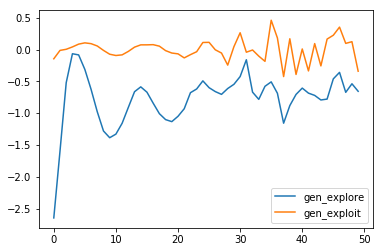

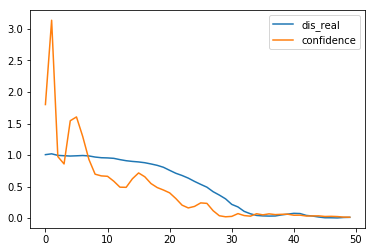

Generation 1  fitness : -21.43872934872295
#################################
Measured population fitness : 5s
population fitness : [ -93.6658185   -25.41994481  -50.65890257  -93.01251701  -91.74594435
  -75.11462102  -40.66227113 -118.28416298  -30.94060804  -92.78728915]
mean fit : -71.22920795587682
tensor([[0.2988, 0.0237, 0.0070,  ..., 0.1005, 0.3495, 0.2100],
        [0.1530, 0.2434, 0.0434,  ..., 0.0421, 0.1892, 0.0866],
        [0.2436, 0.0010, 0.2553,  ..., 0.3143, 0.4991, 0.3940],
        ...,
        [0.0121, 0.2124, 0.2141,  ..., 0.1514, 0.0196, 0.1221],
        [0.0189, 0.1173, 0.1913,  ..., 0.1476, 0.0328, 0.4490],
        [0.0603, 0.0207, 0.1109,  ..., 0.0205, 0.1130, 0.1741]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


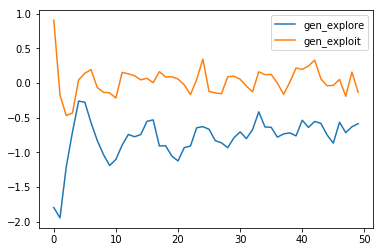

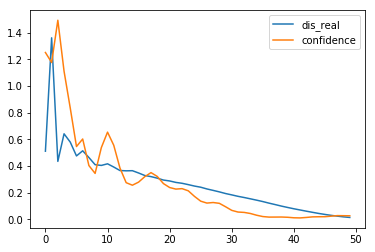

Generation 2  fitness : -25.419944806239755
#################################
Measured population fitness : 8s
population fitness : [ -14.0006855   -67.30272818  -36.73878768  -24.72815844  -19.46224375
 -117.21608343  -93.83986155  -33.20488983  -48.14131621  -95.83796796]
mean fit : -55.04727225301558
tensor([[0.2607, 0.0539, 0.0447,  ..., 0.0095, 0.4333, 0.0100],
        [0.0266, 0.1148, 0.0447,  ..., 0.1376, 0.2571, 0.2430],
        [0.2502, 0.0571, 0.2497,  ..., 0.1194, 0.0802, 0.0835],
        ...,
        [0.3744, 0.0903, 0.0089,  ..., 0.3113, 0.0679, 0.0568],
        [0.0618, 0.4680, 0.1388,  ..., 0.1798, 0.1151, 0.3702],
        [0.0971, 0.4031, 0.0518,  ..., 0.1204, 0.1117, 0.3805]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


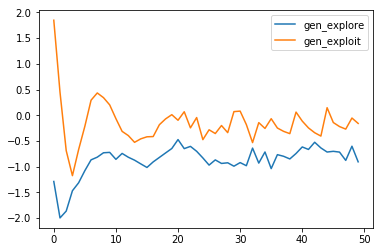

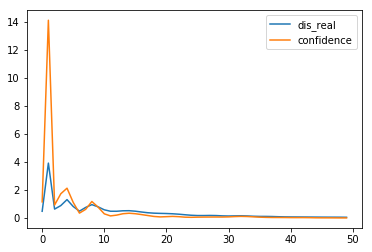

Generation 3  fitness : -14.000685499798463
#################################
Measured population fitness : 5s
population fitness : [ -24.58882724  -94.15331367  -94.27185533  -32.06581771  -94.63596583
  -99.71617293 -122.86189688  -31.6270859   -28.79532369 -111.39479081]
mean fit : -73.41110500005128
tensor([[0.2685, 0.3514, 0.2648,  ..., 0.1853, 0.1107, 0.1740],
        [0.2113, 0.0371, 0.2016,  ..., 0.0628, 0.1465, 0.0471],
        [0.0657, 0.1496, 0.0240,  ..., 0.2406, 0.2669, 0.2637],
        ...,
        [0.0879, 0.0429, 0.1241,  ..., 0.0609, 0.0616, 0.1326],
        [0.3318, 0.2445, 0.0817,  ..., 0.1179, 0.3858, 0.4905],
        [0.3377, 0.0734, 0.0109,  ..., 0.2662, 0.1599, 0.1306]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


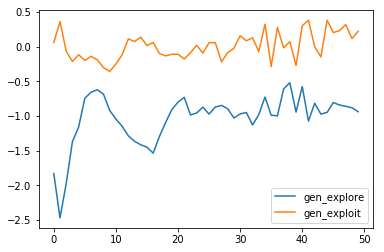

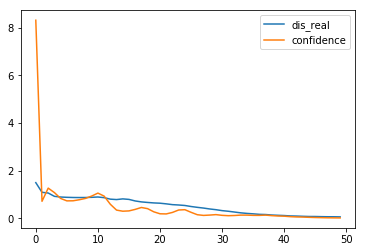

Generation 4  fitness : -24.588827243221278
#################################
Measured population fitness : 3s
population fitness : [ -40.59266138  -95.93838694  -30.75602286  -93.56788062 -110.11830766
  -98.15934963 -108.32624157  -31.92701401 -112.52354164  -93.40359612]
mean fit : -81.53130024263623
tensor([[0.0922, 0.0685, 0.2316,  ..., 0.0381, 0.1128, 0.3828],
        [0.1625, 0.0507, 0.0623,  ..., 0.0705, 0.1010, 0.0310],
        [0.0551, 0.2222, 0.3155,  ..., 0.1977, 0.0016, 0.2521],
        ...,
        [0.2458, 0.1561, 0.1338,  ..., 0.0396, 0.0132, 0.0696],
        [0.6169, 0.0937, 0.1664,  ..., 0.0429, 0.3044, 0.0349],
        [0.2885, 0.4047, 0.0651,  ..., 0.1718, 0.0554, 0.0303]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


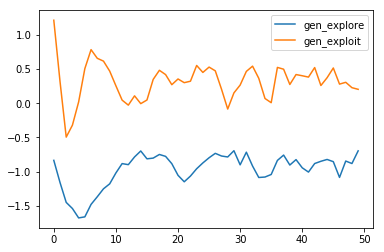

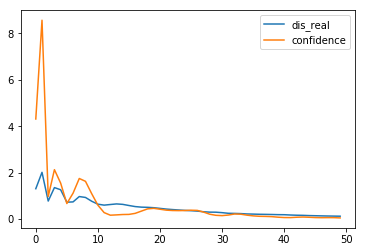

Generation 5  fitness : -30.756022857120225
#################################
Measured population fitness : 7s
population fitness : [ -92.98822404  -42.63213357  -94.41406273  -38.72680607  -23.02432235
 -121.41097861  -29.0327893   -51.34268827   -3.08305653  -93.20488099]
mean fit : -58.98599424609738
tensor([[0.0111, 0.2419, 0.1249,  ..., 0.0668, 0.1601, 0.1487],
        [0.1011, 0.0236, 0.0635,  ..., 0.1049, 0.1573, 0.3129],
        [0.3449, 0.0722, 0.0005,  ..., 0.1437, 0.1317, 0.0824],
        ...,
        [0.1219, 0.2566, 0.1166,  ..., 0.1705, 0.0903, 0.3038],
        [0.1769, 0.0095, 0.1887,  ..., 0.0327, 0.1148, 0.2402],
        [0.3826, 0.3081, 0.0972,  ..., 0.1998, 0.0039, 0.0555]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


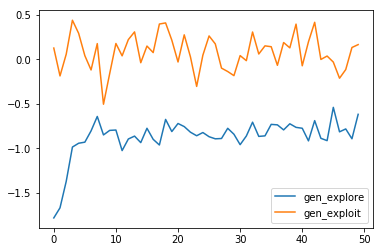

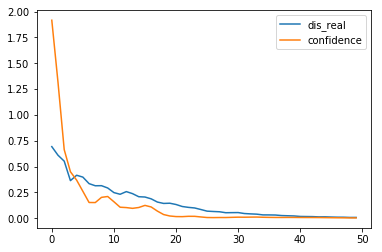

Generation 6  fitness : -3.0830565281050113
#################################
Measured population fitness : 7s
population fitness : [ -24.67073422  -38.77720643  -23.0610466   -93.7814485   -32.11046481
  -53.38598373  -31.95995435  -94.47524005  -93.6808537  -123.10947667]
mean fit : -60.90124090681233
tensor([[0.0595, 0.3009, 0.0272,  ..., 0.0782, 0.0520, 0.3410],
        [0.2551, 0.1128, 0.1725,  ..., 0.0535, 0.3515, 0.1949],
        [0.2527, 0.1571, 0.1348,  ..., 0.0433, 0.0376, 0.2205],
        ...,
        [0.3014, 0.2948, 0.0673,  ..., 0.0319, 0.1739, 0.1665],
        [0.0140, 0.2066, 0.3408,  ..., 0.1605, 0.0919, 0.1082],
        [0.1356, 0.0779, 0.0299,  ..., 0.1569, 0.0965, 0.0436]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


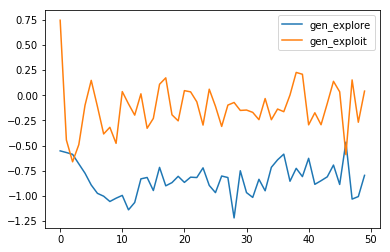

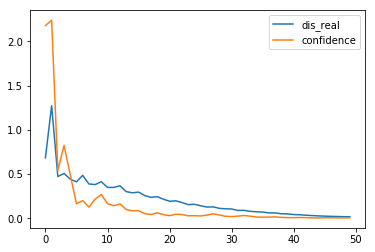

Generation 7  fitness : -23.061046602946217
#################################
Measured population fitness : 9s
population fitness : [ -31.30924926 -114.08162271  -25.09365401  -31.51498849  -37.20991077
  -29.3724961  -123.01475498  -37.41433308  -22.27672333  -29.39073032]
mean fit : -48.0678463035671
tensor([[0.4086, 0.2051, 0.1017,  ..., 0.1597, 0.4105, 0.2006],
        [0.2086, 0.0175, 0.0601,  ..., 0.0639, 0.3825, 0.1716],
        [0.1265, 0.3427, 0.0196,  ..., 0.0443, 0.0995, 0.4861],
        ...,
        [0.1187, 0.0871, 0.1839,  ..., 0.2713, 0.0120, 0.1433],
        [0.1112, 0.0674, 0.1582,  ..., 0.1183, 0.0741, 0.0270],
        [0.0867, 0.3202, 0.2597,  ..., 0.1272, 0.3144, 0.1602]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


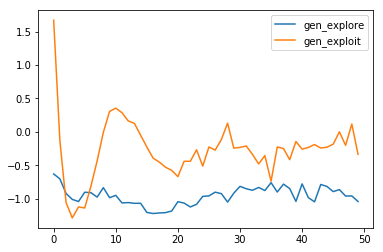

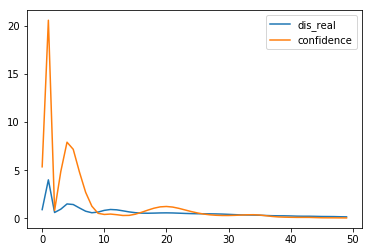

Generation 8  fitness : -22.276723333089947
#################################
Measured population fitness : 8s
population fitness : [ -32.82505475  -32.27740785  -35.83317627 -113.1215522   -93.01472925
  -18.66978785  -93.84537847  -24.14282563  -30.7763134   -31.31886845]
mean fit : -50.58250941110386
tensor([[0.0822, 0.0024, 0.2043,  ..., 0.2626, 0.0055, 0.0992],
        [0.0922, 0.2072, 0.3067,  ..., 0.2229, 0.3848, 0.0496],
        [0.0079, 0.0245, 0.1030,  ..., 0.1036, 0.1234, 0.1347],
        ...,
        [0.0394, 0.4232, 0.0604,  ..., 0.2972, 0.2829, 0.2099],
        [0.0371, 0.1930, 0.0178,  ..., 0.3367, 0.0707, 0.0038],
        [0.1014, 0.0935, 0.0836,  ..., 0.1998, 0.0240, 0.2547]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


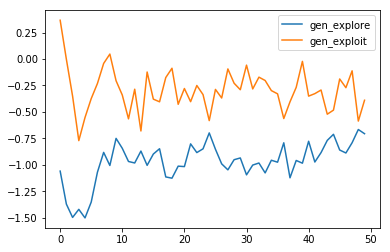

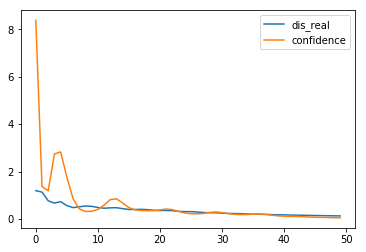

Generation 9  fitness : -18.66978784709548
#################################
Measured population fitness : 8s
population fitness : [ -29.29860969  -29.87372572 -111.93461436  -37.98454556  -24.49432515
  -31.45579671  -19.4085171  -112.03232757  -41.762386   -112.7485147 ]
mean fit : -55.09933625641147
tensor([[0.0178, 0.1771, 0.0060,  ..., 0.0126, 0.4047, 0.3091],
        [0.1698, 0.0071, 0.0039,  ..., 0.2002, 0.0360, 0.1216],
        [0.3503, 0.0508, 0.1752,  ..., 0.2186, 0.3551, 0.0277],
        ...,
        [0.0054, 0.3511, 0.2131,  ..., 0.2672, 0.0252, 0.2036],
        [0.0640, 0.0581, 0.1881,  ..., 0.0624, 0.3001, 0.1593],
        [0.2831, 0.1643, 0.1893,  ..., 0.1755, 0.4244, 0.2066]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


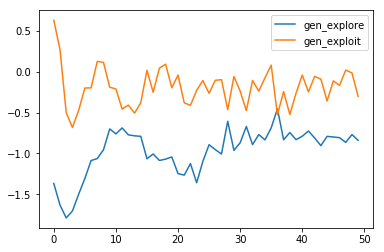

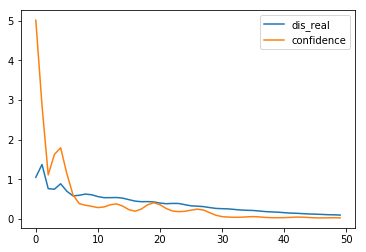

Generation 10  fitness : -19.408517095225626
#################################
Measured population fitness : 8s
population fitness : [-111.37547395  -54.3714239   -25.09405712 -111.9050869   -41.05258696
  -31.2200417   -32.80865683  -27.42352594 -114.26268905  -34.78808005]
mean fit : -58.43016223848345
tensor([[0.1872, 0.0289, 0.1806,  ..., 0.3575, 0.2159, 0.1338],
        [0.1031, 0.0742, 0.1366,  ..., 0.1910, 0.2155, 0.3125],
        [0.0776, 0.3221, 0.1499,  ..., 0.2561, 0.0692, 0.1019],
        ...,
        [0.0451, 0.1173, 0.0006,  ..., 0.3455, 0.1573, 0.1257],
        [0.0421, 0.1524, 0.0116,  ..., 0.3216, 0.2723, 0.1637],
        [0.0952, 0.1274, 0.0777,  ..., 0.2384, 0.0683, 0.0405]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


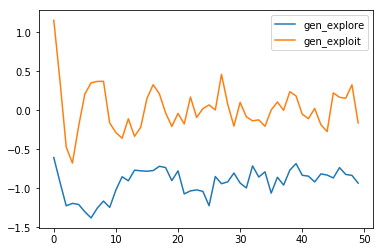

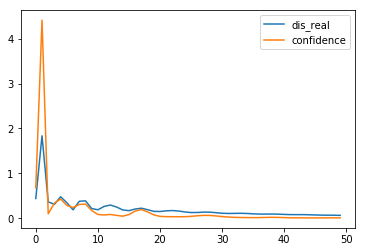

Generation 11  fitness : -25.094057118037775
#################################
Measured population fitness : 11s
population fitness : [-17.21816869 -31.15714948 -61.08784142 -38.36536501 -14.46874707
 -25.21197053 -29.88687132 -31.90981093 -28.84744152 -22.13457985]
mean fit : -30.02879458247896
tensor([[0.1505, 0.2216, 0.2052,  ..., 0.1597, 0.0460, 0.1480],
        [0.2039, 0.0846, 0.0782,  ..., 0.2695, 0.0203, 0.1096],
        [0.1538, 0.3150, 0.1206,  ..., 0.1014, 0.0048, 0.0243],
        ...,
        [0.1308, 0.1079, 0.0046,  ..., 0.2511, 0.1740, 0.1399],
        [0.0297, 0.1693, 0.1921,  ..., 0.3364, 0.1185, 0.1715],
        [0.0173, 0.1376, 0.2230,  ..., 0.3247, 0.1577, 0.2420]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


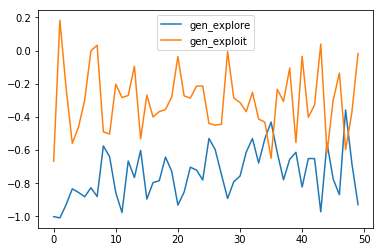

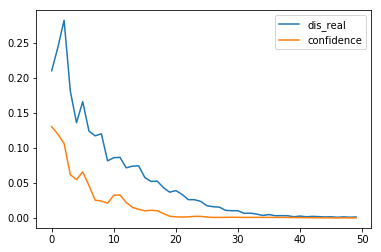

Generation 12  fitness : -14.468747068896894
#################################
Measured population fitness : 11s
population fitness : [-21.99154538 -39.21260532 -19.47871461 -31.703991   -22.71458339
 -20.76204638  -6.9456991  -27.77918911 -38.77340049 -34.18365619]
mean fit : -26.354543098006978
tensor([[0.0402, 0.3648, 0.2149,  ..., 0.1077, 0.0090, 0.0662],
        [0.2457, 0.3440, 0.0965,  ..., 0.0229, 0.1269, 0.0291],
        [0.0362, 0.1354, 0.0472,  ..., 0.1288, 0.0521, 0.0003],
        ...,
        [0.1330, 0.2316, 0.0947,  ..., 0.1029, 0.1010, 0.2072],
        [0.1610, 0.3083, 0.1344,  ..., 0.0309, 0.0619, 0.0162],
        [0.1018, 0.2734, 0.1118,  ..., 0.2825, 0.0071, 0.0952]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


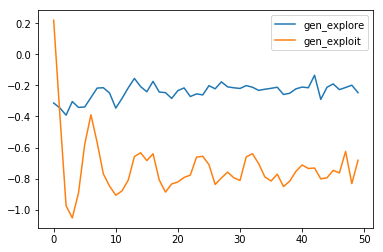

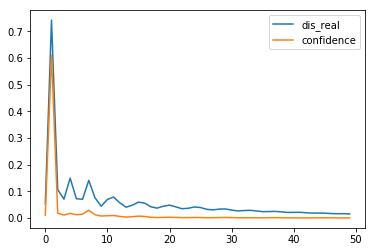

Generation 13  fitness : -6.945699095496367
#################################
Measured population fitness : 8s
population fitness : [ -24.86458232  -27.53846139  -14.7663145  -111.58697839 -100.87005212
  -30.304446    -27.92296898  -14.29627841  -10.6878162   -19.74246783]
mean fit : -38.25803661674135
tensor([[0.3232, 0.2328, 0.2360,  ..., 0.0598, 0.0861, 0.1800],
        [0.0081, 0.0758, 0.2201,  ..., 0.2591, 0.1948, 0.2235],
        [0.2206, 0.0865, 0.1357,  ..., 0.1506, 0.3250, 0.2158],
        ...,
        [0.0608, 0.2313, 0.2950,  ..., 0.2069, 0.2015, 0.3703],
        [0.0472, 0.2869, 0.1441,  ..., 0.0894, 0.1315, 0.2240],
        [0.0087, 0.2954, 0.1330,  ..., 0.1221, 0.0008, 0.0385]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


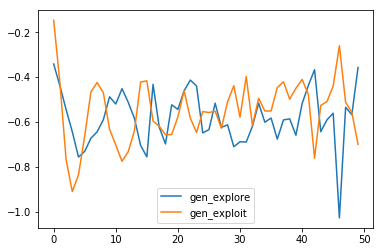

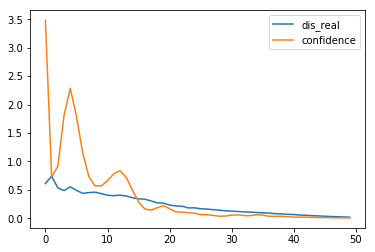

Generation 14  fitness : -10.687816200677485
#################################
Measured population fitness : 10s
population fitness : [ -22.99530251  -25.37704849  -24.87482337  -26.65815302  -22.97198899
  -27.55013112  -22.10016586 -113.5760044   -12.10336424  -36.64128146]
mean fit : -33.48482634663011
tensor([[0.1374, 0.0960, 0.0622,  ..., 0.1062, 0.1535, 0.3537],
        [0.0004, 0.1608, 0.2775,  ..., 0.0199, 0.2497, 0.3714],
        [0.0344, 0.3974, 0.0707,  ..., 0.1966, 0.0476, 0.1608],
        ...,
        [0.0593, 0.0967, 0.1530,  ..., 0.1632, 0.0680, 0.3190],
        [0.1331, 0.2196, 0.0528,  ..., 0.3464, 0.3021, 0.3085],
        [0.1486, 0.2101, 0.2058,  ..., 0.2149, 0.0320, 0.3070]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


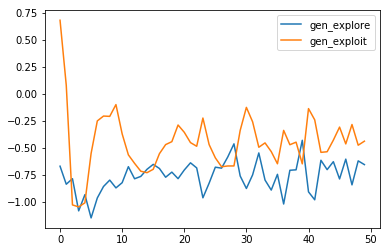

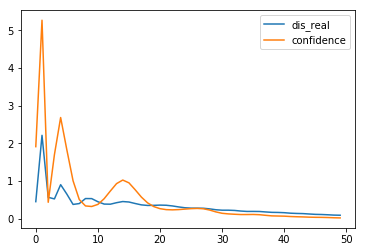

Generation 15  fitness : -12.103364235807327
#################################
Measured population fitness : 9s
population fitness : [ -28.24735003  -24.31392647  -19.35857106 -120.76096206  -30.29809877
 -113.7637973   -42.40957719  -21.84979453  -19.44532642  -18.63560625]
mean fit : -43.90830100722085
tensor([[0.0461, 0.1142, 0.3371,  ..., 0.0864, 0.1473, 0.2661],
        [0.1244, 0.0553, 0.0418,  ..., 0.0444, 0.2102, 0.3222],
        [0.1174, 0.0858, 0.1771,  ..., 0.0798, 0.1885, 0.3888],
        ...,
        [0.0069, 0.2262, 0.0912,  ..., 0.3282, 0.2679, 0.3960],
        [0.0713, 0.2296, 0.2944,  ..., 0.0321, 0.3934, 0.3567],
        [0.1349, 0.2754, 0.2549,  ..., 0.1540, 0.2816, 0.2002]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


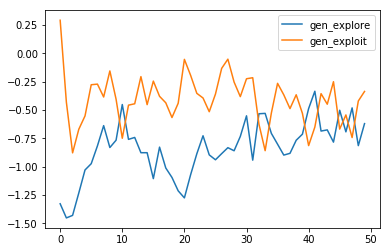

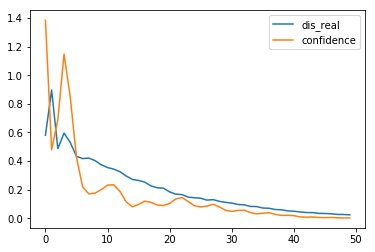

Generation 16  fitness : -18.63560624782182
#################################
Measured population fitness : 10s
population fitness : [-18.74501493 -23.93066764 -31.33988904 -25.31874682 -17.39970922
 -22.53096906 -24.44402837 -55.81698473 -27.10156415 -20.96766271]
mean fit : -26.759523667671214
tensor([[0.0576, 0.2970, 0.1722,  ..., 0.0257, 0.2792, 0.4294],
        [0.1096, 0.2756, 0.2520,  ..., 0.0553, 0.1545, 0.3548],
        [0.0118, 0.2649, 0.2494,  ..., 0.1335, 0.2303, 0.3820],
        ...,
        [0.1033, 0.2478, 0.3817,  ..., 0.1990, 0.3480, 0.1634],
        [0.0173, 0.1118, 0.1902,  ..., 0.0098, 0.1118, 0.3519],
        [0.0098, 0.2272, 0.2023,  ..., 0.2051, 0.2360, 0.3296]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


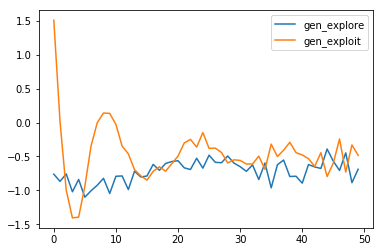

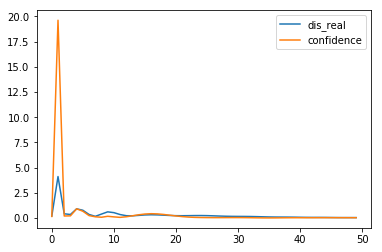

Generation 17  fitness : -17.399709224348097
#################################
Measured population fitness : 11s
population fitness : [-113.6997692   -28.16500932  -21.92285587  -42.44492773  -34.79962126
  -18.53161025  -27.21080195  -20.24050361  -17.69391138  -17.19860981]
mean fit : -34.19076203604699
tensor([[0.2078, 0.2752, 0.1573,  ..., 0.0872, 0.0731, 0.2683],
        [0.0130, 0.2965, 0.1988,  ..., 0.0966, 0.2128, 0.1896],
        [0.1101, 0.0861, 0.2081,  ..., 0.0095, 0.3274, 0.1859],
        ...,
        [0.2168, 0.2270, 0.2601,  ..., 0.0463, 0.2766, 0.2536],
        [0.0679, 0.1575, 0.1332,  ..., 0.0460, 0.2417, 0.3556],
        [0.0958, 0.3397, 0.3341,  ..., 0.1258, 0.3477, 0.2727]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


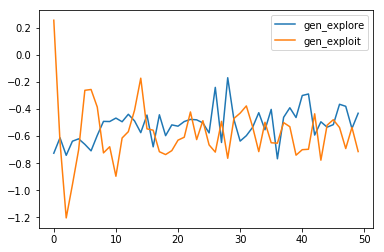

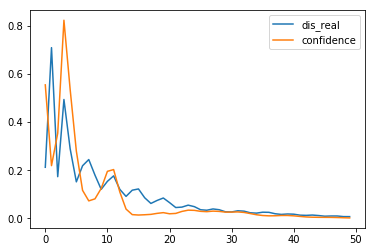

Generation 18  fitness : -17.198609806312685
#################################
Measured population fitness : 6s
population fitness : [-105.92515434  -22.89281609 -120.7279426   -22.96713674  -93.69650378
 -111.41063076  -97.26286054  -28.72072364  -25.50330607  -24.22924985]
mean fit : -65.33363244172045
tensor([[0.0252, 0.2848, 0.2453,  ..., 0.0082, 0.3419, 0.2878],
        [0.0012, 0.3040, 0.2178,  ..., 0.0952, 0.2565, 0.3089],
        [0.0818, 0.3249, 0.1729,  ..., 0.0395, 0.1591, 0.2629],
        ...,
        [0.1569, 0.2938, 0.2489,  ..., 0.0041, 0.1235, 0.2361],
        [0.0355, 0.3286, 0.3048,  ..., 0.0785, 0.1270, 0.2992],
        [0.1155, 0.2729, 0.1487,  ..., 0.0827, 0.1523, 0.2825]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


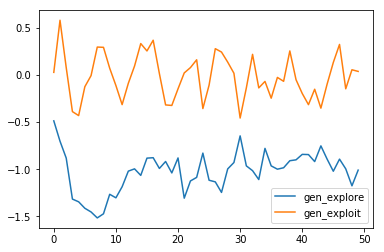

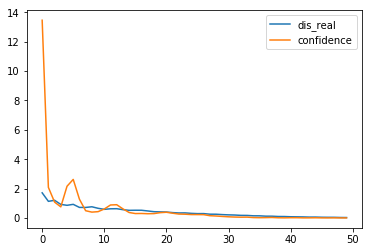

Generation 19  fitness : -22.892816094879556
#################################
Measured population fitness : 10s
population fitness : [-119.58887566  -24.02520469  -25.72734118  -19.72838079  -23.9488418
  -19.73090679  -21.87153444  -33.20057549  -14.65328262 -111.69810636]
mean fit : -41.417304981387716
tensor([[0.1089, 0.1613, 0.2424,  ..., 0.0664, 0.0022, 0.2086],
        [0.0222, 0.0277, 0.2257,  ..., 0.0395, 0.0588, 0.0145],
        [0.0251, 0.2155, 0.2957,  ..., 0.0433, 0.1770, 0.1824],
        ...,
        [0.0696, 0.3655, 0.1709,  ..., 0.0734, 0.2357, 0.1712],
        [0.0941, 0.2146, 0.2235,  ..., 0.0295, 0.3373, 0.1969],
        [0.1296, 0.2332, 0.4218,  ..., 0.0537, 0.1409, 0.1322]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Trained GAN : 2s
Evolved : 0s


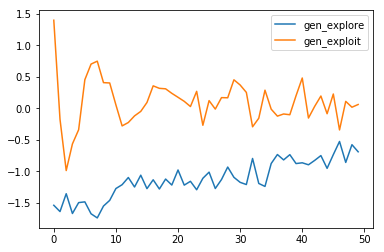

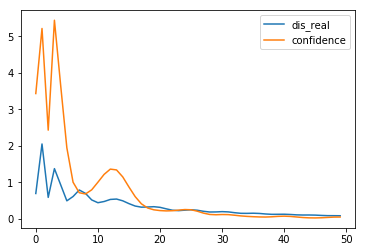

Generation 20  fitness : -14.653282620470637
#################################


KeyboardInterrupt: 

In [4]:
#population_size = 10
#max_population = population_size
#max_population_batch = 2
#out_size = population_size
#n_generations = 300

#randomly inititialise starting population
population = []

for p in range(population_size):
    creat = Creature(env.observation_space.shape[0],creature_out_size).to(device)
    
    #pars = torch.from_numpy(np.random.uniform(0,1,get_params(creat).numel())).type('torch.FloatTensor').to(device)
    pars = torch.tanh(get_params(creat))
    creat = set_params(creat,pars)
    population.append(creat)


print("starting training")
print(len(get_params(Creature(env.observation_space.shape[0],creature_out_size))))

old_population = []
old_fitnesses = []
all_fitnesses = []
gen = Generator(input_num,output_num,device).to(device)
dis = Discriminator().to(device)

for i in range(n_generations):
    start_time = time.time()
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.001,betas=(0.9,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.001,betas=(0.9,0.999))
   
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)
    print("Measured population fitness : {}s".format(int(time.time() - start_time)))
    
    #Store populations and remove older ones
    old_population.append(population)
    old_fitnesses.append(p_fitness_)
    all_fitnesses.append(p_fitness_)
    if len(old_population) > max_population_batch:
        old_population.pop(0)
        old_fitnesses.pop(0)
    #if len(all_fitnesses) > 5:
    #    all_fitnesses.pop(0)
        
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))

    #setup data for GAN
    population_batch = np.concatenate(np.array(old_population))
    fitness_batch = np.concatenate(np.array(old_fitnesses))
    
    #normalize fitnesses
    epsilon = 0.000001
    fitness_batch_normed = ((fitness_batch - np.mean(all_fitnesses))/np.std(all_fitnesses))
    #fitness_batch_normed = (fitness_batch-np.mean(all_fitnesses))/(np.max(all_fitnesses)-np.min(all_fitnesses))
    #fitness_batch_normed = (fitness_batch-np.min(all_fitnesses))/np.sum(all_fitnesses)
    #Train GAN
    start_time = time.time()
    gen_explore_all,gen_exploit_all, dis_loss ,dis_confidence_all= train_gan(population_batch
                                                                                       ,fitness_batch_normed,
              batch_size =fitness_batch.size,n_epochs = 50)
    print("Trained GAN : {}s".format(int(time.time() - start_time)))
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 500)
    
    #Scale of normal distribution used for mutation
    
    mr = np.random.choice([mutation_rate, 0], fitness_batch.shape,p=[creature_mutation_rate,1-creature_mutation_rate])
    
    all_r = 1
    all_r = np.random.choice([1, 0], p_fitness_.shape,p=[all_r,1-all_r])
    al_lr = all_r * all_a#* np.abs(np.random.normal(scale = 1,size = p_fitness_.shape))*all_a
   # al_lr = np.array([0]*p_fitness_.size)
    #mate and mutate population
    start_time = time.time()
    population = evolve(population,out_size,gen,p_fitness_,
                                        mr,mutation_scale,al_lr)
    gen.hidden = None
    print("Evolved : {}s".format(int(time.time() - start_time)))
    
    plt.plot(gen_explore_all,label='gen_explore')
    plt.plot(gen_exploit_all,label='gen_exploit')
    plt.legend()
    plt.show()
    plt.plot(dis_loss,label='dis_real')
    plt.plot(dis_confidence_all,label='confidence')
    #plt.ylim(0,5)
    plt.legend()
    plt.show()
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness_)))
    print("#################################")


In [ ]:
env = gym.make(envs[-2]).unwrapped

p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)


In [ ]:
env = gym.make(envs[-2]).unwrapped
fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 2000)
print(fitness)

In [ ]:
print(fitness)